:**# Step 1: Data Generation (balanced, linearly separable)**

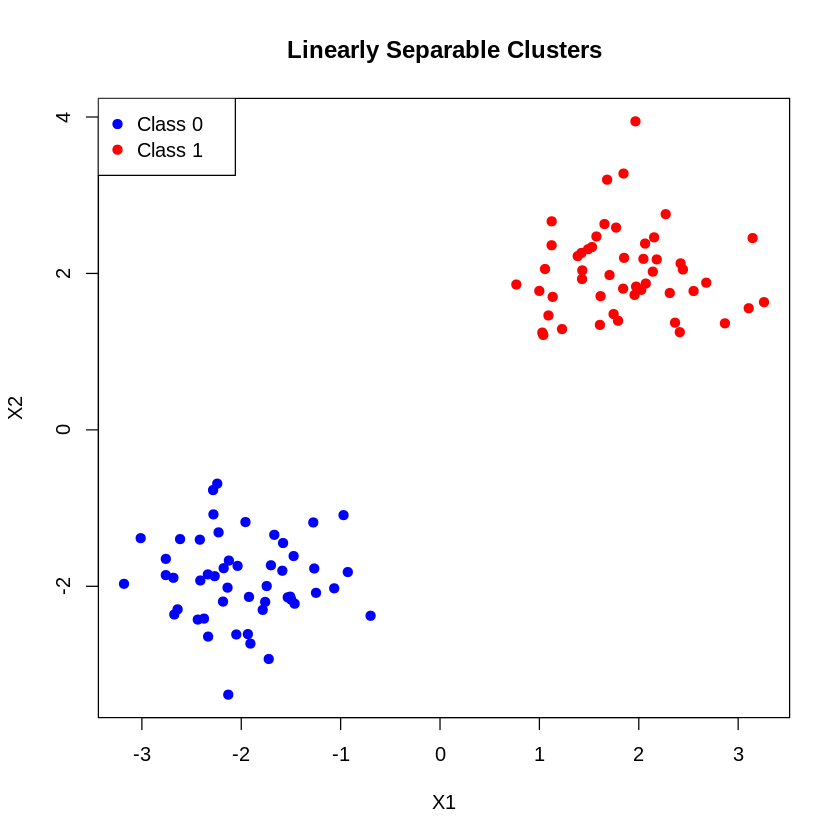

In [ ]:
n <- 50
m <- 2
set.seed(123)

# Generate class 0
X0 <- matrix(rnorm(n * m, mean = -2, sd = 0.6), ncol = m)
y0 <- rep(0, n)

# Generate class 1
X1 <- matrix(rnorm(n * m, mean = 2, sd = 0.6), ncol = m)
y1 <- rep(1, n)

# Combine both classes
X <- rbind(X0, X1)
y <- c(y0, y1)

# Make a data frame for easy handling
data <- data.frame(X1 = X[,1], X2 = X[,2], y = as.factor(y))

# Plot
plot(data$X1, data$X2,
     col = ifelse(data$y == 1, "red", "blue"),
     pch = 19,
     main = "Linearly Separable Clusters",
     xlab = "X1",
     ylab = "X2")
legend("topleft", legend = c("Class 0", "Class 1"),
       col = c("blue", "red"), pch = 19)


**# Step 2: Stable IRLS (Unregularized Logistic Regression)**

Final beta coefficients:
        [,1]   [,2]   [,3]
[1,] -0.1697 6.6601 8.5081


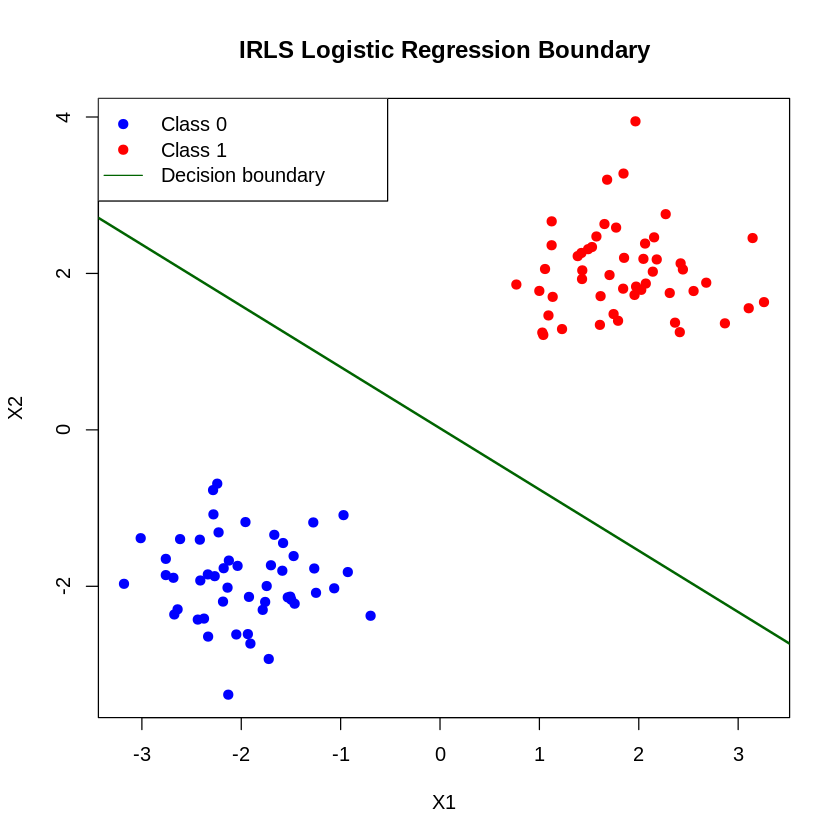

In [ ]:
# Add intercept column
X_mat <- cbind(1, as.matrix(X))
y_vec <- as.numeric(as.character(y))

# Initialize beta
beta <- rep(0, ncol(X_mat))

# Settings
max_iter <- 25
tol <- 1e-6

for (i in 1:max_iter) {
  z <- X_mat %*% beta
  p <- 1 / (1 + exp(-z))
  p <- pmin(pmax(p, 1e-6), 1 - 1e-6)
  W <- diag(as.vector(p * (1 - p)))
  z_adj <- z + (y_vec - p) / (p * (1 - p))
  XtWX <- t(X_mat) %*% W %*% X_mat
  XtWX <- XtWX + diag(1e-6, ncol(XtWX))

  beta_new <- solve(XtWX, t(X_mat) %*% W %*% z_adj)

  # Check convergence safely
  diff <- abs(beta_new - beta)
  if (all(!is.na(diff)) && max(diff) < tol) {
    cat("Converged in", i, "iterations\n")
    beta <- beta_new
    break
  }

  beta <- beta_new
}

# Final coefficients
cat("Final beta coefficients:\n")
print(round(t(beta), 4))

# Plot
plot(X, col = ifelse(y_vec == 1, "red", "blue"), pch = 19,
     xlab = "X1", ylab = "X2", main = "IRLS Logistic Regression Boundary")
abline(-beta[1]/beta[3], -beta[2]/beta[3], col = "darkgreen", lwd = 2)
legend("topleft", legend = c("Class 0", "Class 1", "Decision boundary"),
       col = c("blue", "red", "darkgreen"),
       pch = c(19, 19, NA), lty = c(NA, NA, 1))


**# Step 3: Regularized IRLS (L2 / Ridge Logistic Regression)**

✅ Regularized IRLS converged in 10 iterations
Final regularized beta coefficients:
       [,1]   [,2]   [,3]
[1,] 0.0445 1.8887 2.0617


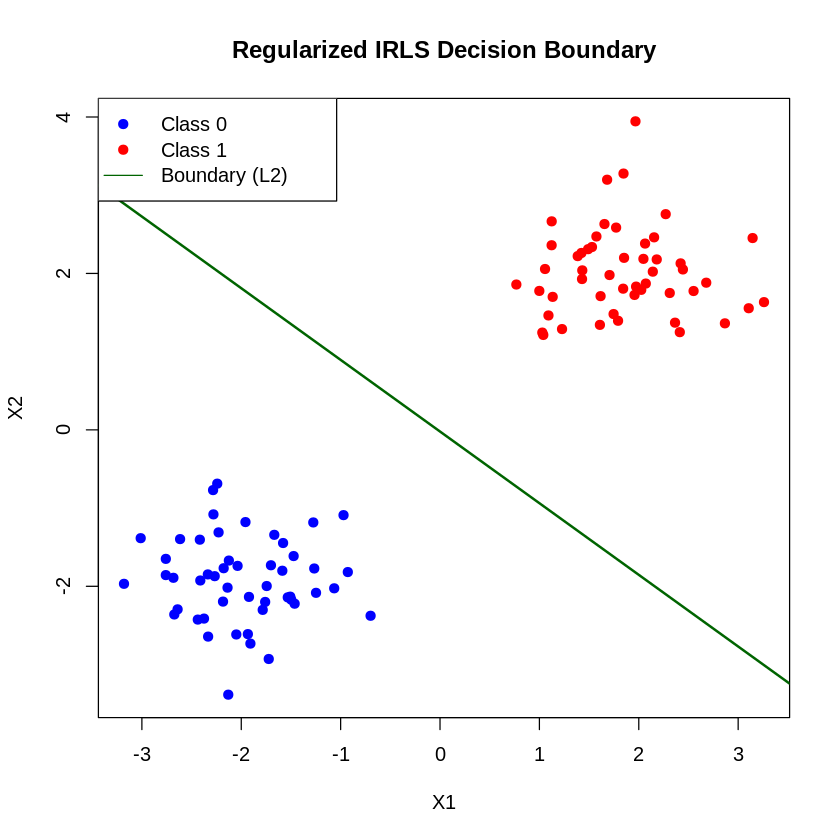

In [ ]:
beta <- rep(0, ncol(X_mat))

# Regularization strength (lambda)
lambda <- 0.1

max_iter <- 25
tol <- 1e-6

for (i in 1:max_iter) {
  z <- X_mat %*% beta
  p <- 1 / (1 + exp(-z))
  p <- pmin(pmax(p, 1e-6), 1 - 1e-6)
  W <- diag(as.vector(p * (1 - p)))
  z_adj <- z + (y_vec - p) / (p * (1 - p))

  # Weighted least squares update + L2 penalty
  XtWX <- t(X_mat) %*% W %*% X_mat
  P <- diag(c(0, rep(1, ncol(X_mat) - 1)))
  beta_new <- solve(XtWX + lambda * P, t(X_mat) %*% W %*% z_adj)

  # Convergence check
  diff <- abs(beta_new - beta)
  if (all(!is.na(diff)) && max(diff) < tol) {
    cat("✅ Regularized IRLS converged in", i, "iterations\n")
    beta <- beta_new
    break
  }

  beta <- beta_new
}

cat("Final regularized beta coefficients:\n")
print(round(t(beta), 4))

# Plot
plot(X, col = ifelse(y_vec == 1, "red", "blue"), pch = 19,
     xlab = "X1", ylab = "X2", main = "Regularized IRLS Decision Boundary")

# Decision boundary
abline(-beta[1]/beta[3], -beta[2]/beta[3], col = "darkgreen", lwd = 2)

legend("topleft", legend = c("Class 0", "Class 1", "Boundary (L2)"),
       col = c("blue", "red", "darkgreen"),
       pch = c(19, 19, NA), lty = c(NA, NA, 1))


**# Step 4: Adding Outliers & Comparing Models**

Unregularized β:
        [,1]   [,2]   [,3]
[1,] -0.0183 0.2763 0.7166

Regularized β:
        [,1]  [,2]   [,3]
[1,] -0.0176 0.282 0.7097


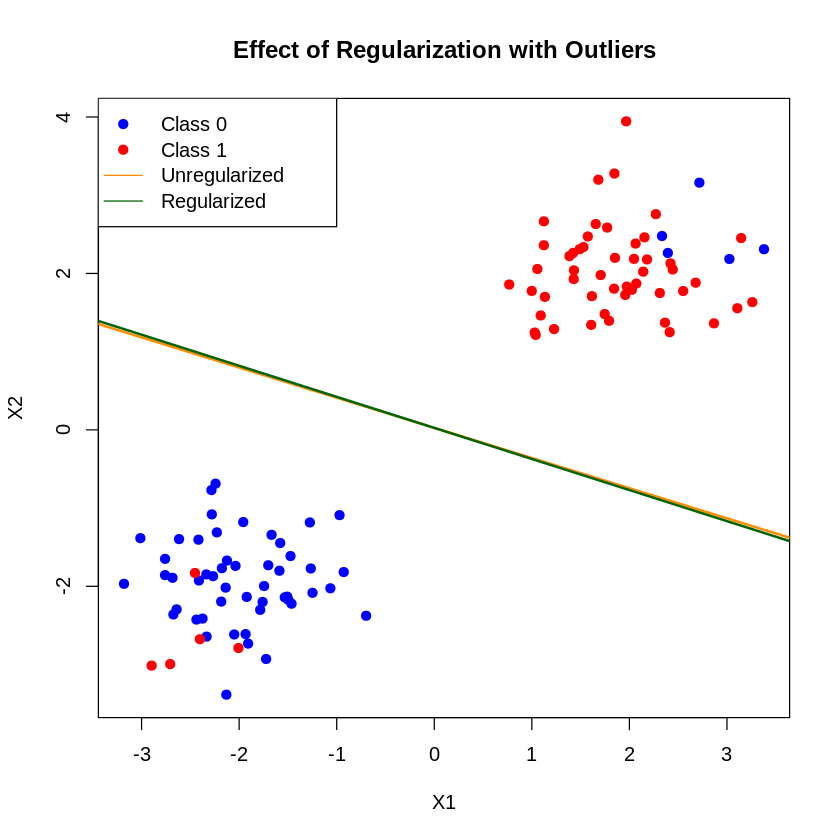

In [ ]:
set.seed(123)
n <- 50
m <- 2
X0 <- matrix(rnorm(n * m, mean = -2, sd = 0.6), ncol = m)
y0 <- rep(0, n)
X1 <- matrix(rnorm(n * m, mean = 2, sd = 0.6), ncol = m)
y1 <- rep(1, n)
X <- rbind(X0, X1)
y <- c(y0, y1)

# Add outliers
outliers0 <- matrix(rnorm(5 * m, mean = 2.5, sd = 0.4), ncol = m)  # class 0 misplaced
outliers1 <- matrix(rnorm(5 * m, mean = -2.5, sd = 0.4), ncol = m) # class 1 misplaced

X <- rbind(X, outliers0, outliers1)
y <- c(y, rep(0, 5), rep(1, 5))

# Convert to data frame
data <- data.frame(X1 = X[,1], X2 = X[,2], y = as.factor(y))
y_vec <- as.numeric(as.character(y))
X_mat <- cbind(1, as.matrix(X))

# Unregularized IRLS
irls_unreg <- function(X_mat, y_vec, max_iter = 25, tol = 1e-6) {
  beta <- rep(0, ncol(X_mat))
  for (i in 1:max_iter) {
    z <- X_mat %*% beta
    p <- 1 / (1 + exp(-z))
    p <- pmin(pmax(p, 1e-6), 1 - 1e-6)
    W <- diag(as.vector(p * (1 - p)))
    z_adj <- z + (y_vec - p) / (p * (1 - p))
    XtWX <- t(X_mat) %*% W %*% X_mat + diag(1e-6, ncol(X_mat))
    beta_new <- solve(XtWX, t(X_mat) %*% W %*% z_adj)
    if (max(abs(beta_new - beta)) < tol) break
    beta <- beta_new
  }
  return(beta)
}

# Regularized IRLS (L2)
irls_reg <- function(X_mat, y_vec, lambda = 0.1, max_iter = 25, tol = 1e-6) {
  beta <- rep(0, ncol(X_mat))
  for (i in 1:max_iter) {
    z <- X_mat %*% beta
    p <- 1 / (1 + exp(-z))
    p <- pmin(pmax(p, 1e-6), 1 - 1e-6)
    W <- diag(as.vector(p * (1 - p)))
    z_adj <- z + (y_vec - p) / (p * (1 - p))
    P <- diag(c(0, rep(1, ncol(X_mat) - 1)))
    XtWX <- t(X_mat) %*% W %*% X_mat
    beta_new <- solve(XtWX + lambda * P, t(X_mat) %*% W %*% z_adj)
    if (max(abs(beta_new - beta)) < tol) break
    beta <- beta_new
  }
  return(beta)
}

# Compute both betas
beta_unreg <- irls_unreg(X_mat, y_vec)
beta_reg   <- irls_reg(X_mat, y_vec, lambda = 0.1)



cat("Unregularized β:\n")
print(round(t(beta_unreg), 4))
cat("\nRegularized β:\n")
print(round(t(beta_reg), 4))


# Plot
plot(X, col = ifelse(y_vec == 1, "red", "blue"), pch = 19,
     xlab = "X1", ylab = "X2",
     main = "Effect of Regularization with Outliers")

# decision boundaries
abline(-beta_unreg[1]/beta_unreg[3], -beta_unreg[2]/beta_unreg[3],
       col = "darkorange", lwd = 2)
abline(-beta_reg[1]/beta_reg[3], -beta_reg[2]/beta_reg[3],
       col = "darkgreen", lwd = 2)

legend("topleft",
       legend = c("Class 0", "Class 1", "Unregularized", "Regularized"),
       col = c("blue", "red", "darkorange", "darkgreen"),
       pch = c(19,19,NA,NA), lty = c(NA,NA,1,1))


**Step 5: Dataset Challenges (Small vs Large & Balanced vs Imbalanced)**

In [ ]:
set.seed(123)
make_data <- function(n, m = 2, balance = TRUE) {
  if (balance) {
    n0 <- n1 <- n
  } else {
    n0 <- round(0.7 * n)  # 70% class 0
    n1 <- n - n0          # 30% class 1
  }
  X0 <- matrix(rnorm(n0 * m, mean = -2, sd = 0.6), ncol = m)
  X1 <- matrix(rnorm(n1 * m, mean = 2, sd = 0.6), ncol = m)
  X <- rbind(X0, X1)
  y <- c(rep(0, n0), rep(1, n1))
  list(X = X, y = y)
}

# Run experiment
test_dataset <- function(n, balance = TRUE, lambda = 0.1) {
  data <- make_data(n, m = 2, balance)
  X_mat <- cbind(1, as.matrix(data$X))
  y_vec <- data$y
  beta_unreg <- irls_unreg(X_mat, y_vec)
  beta_reg <- irls_reg(X_mat, y_vec, lambda)

  # predictions
  pred_unreg <- 1 / (1 + exp(-X_mat %*% beta_unreg))
  pred_reg <- 1 / (1 + exp(-X_mat %*% beta_reg))

  # classify
  yhat_unreg <- ifelse(pred_unreg > 0.5, 1, 0)
  yhat_reg <- ifelse(pred_reg > 0.5, 1, 0)

  acc_unreg <- mean(yhat_unreg == y_vec)
  acc_reg <- mean(yhat_reg == y_vec)

  return(c(Unregularized = acc_unreg, Regularized = acc_reg))
}

# small vs large dataset
acc_small <- test_dataset(n = 30, balance = TRUE)
acc_large <- test_dataset(n = 200, balance = TRUE)

# balanced vs imbalanced
acc_balanced <- test_dataset(n = 100, balance = TRUE)
acc_imbalanced <- test_dataset(n = 100, balance = FALSE)

# Collect results
acc_table <- rbind(
  Small = acc_small,
  Large = acc_large,
  Balanced = acc_balanced,
  Imbalanced = acc_imbalanced
)

print(round(acc_table, 3))


           Unregularized Regularized
Small                  1           1
Large                  1           1
Balanced               1           1
Imbalanced             1           1


**# Step 5 (revised): Dataset Challenges with realistic overlap**

In [ ]:
set.seed(123)
make_data <- function(n, m = 2, balance = TRUE) {
  if (balance) {
    n0 <- n1 <- n
  } else {
    n0 <- round(0.7 * n)
    n1 <- n - n0
  }

  # Add overlap by using closer means and larger sd
  X0 <- matrix(rnorm(n0 * m, mean = -1.5, sd = 1.0), ncol = m)
  X1 <- matrix(rnorm(n1 * m, mean = 1.5,  sd = 1.0), ncol = m)

  X <- rbind(X0, X1)
  y <- c(rep(0, n0), rep(1, n1))
  list(X = X, y = y)
}

test_dataset <- function(n, balance = TRUE, lambda = 0.1) {
  data <- make_data(n, m = 2, balance)
  X_mat <- cbind(1, as.matrix(data$X))
  y_vec <- data$y
  beta_unreg <- irls_unreg(X_mat, y_vec)
  beta_reg <- irls_reg(X_mat, y_vec, lambda)

  p_unreg <- 1 / (1 + exp(-X_mat %*% beta_unreg))
  p_reg <- 1 / (1 + exp(-X_mat %*% beta_reg))

  yhat_unreg <- ifelse(p_unreg > 0.5, 1, 0)
  yhat_reg <- ifelse(p_reg > 0.5, 1, 0)

  acc_unreg <- mean(yhat_unreg == y_vec)
  acc_reg <- mean(yhat_reg == y_vec)

  return(c(Unregularized = acc_unreg, Regularized = acc_reg))
}

# Run all tests again
acc_small <- test_dataset(n = 30, balance = TRUE)
acc_large <- test_dataset(n = 200, balance = TRUE)
acc_balanced <- test_dataset(n = 100, balance = TRUE)
acc_imbalanced <- test_dataset(n = 100, balance = FALSE)

acc_table <- rbind(
  Small = acc_small,
  Large = acc_large,
  Balanced = acc_balanced,
  Imbalanced = acc_imbalanced
)

print(round(acc_table, 3))


           Unregularized Regularized
Small              1.000        1.00
Large              0.988        0.99
Balanced           0.970        0.97
Imbalanced         1.000        1.00


**# Step 5: Visual Comparison - Perfect vs Overlapping Data**

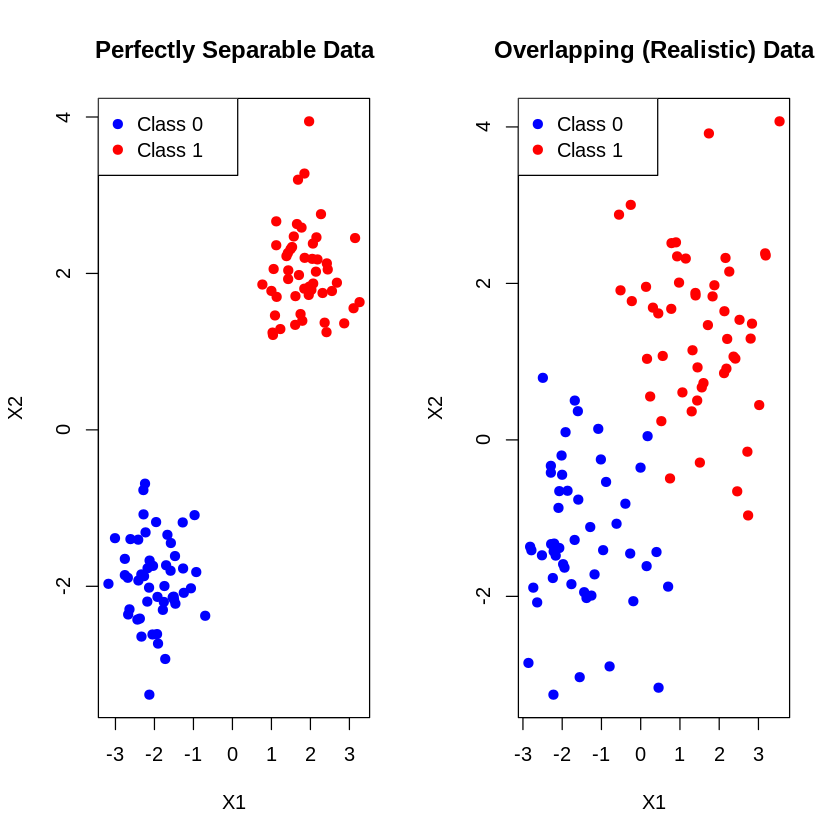

In [ ]:
set.seed(123)
# Perfectly Separable
make_data_old <- function(n = 50, m = 2) {
  X0 <- matrix(rnorm(n * m, mean = -2, sd = 0.6), ncol = m)
  X1 <- matrix(rnorm(n * m, mean = 2,  sd = 0.6), ncol = m)
  X <- rbind(X0, X1)
  y <- c(rep(0, n), rep(1, n))
  list(X = X, y = y)
}

# Overlapping (Realistic)
make_data_new <- function(n = 50, m = 2) {
  X0 <- matrix(rnorm(n * m, mean = -1.5, sd = 1.0), ncol = m)
  X1 <- matrix(rnorm(n * m, mean = 1.5,  sd = 1.0), ncol = m)
  X <- rbind(X0, X1)
  y <- c(rep(0, n), rep(1, n))
  list(X = X, y = y)
}

# Generate both datasets
old <- make_data_old()
new <- make_data_new()

# Plot side by side
par(mfrow = c(1, 2))  # 1 row, 2 plots

# Perfectly separable
plot(old$X, col = ifelse(old$y == 1, "red", "blue"), pch = 19,
     xlab = "X1", ylab = "X2", main = "Perfectly Separable Data")
legend("topleft", legend = c("Class 0", "Class 1"),
       col = c("blue", "red"), pch = 19)

# Overlapping (realistic)
plot(new$X, col = ifelse(new$y == 1, "red", "blue"), pch = 19,
     xlab = "X1", ylab = "X2", main = "Overlapping (Realistic) Data")
legend("topleft", legend = c("Class 0", "Class 1"),
       col = c("blue", "red"), pch = 19)


**This one compares decision boundaries for the unregularized vs regularized IRLS models using the realistic overlapping dataset**

**# Step 5 (continued): Compare Decision Boundaries**

Unregularized β (row):
       [,1]   [,2]    [,3]
[1,] -15.52 41.097 127.355
Regularized β (row):
       [,1]  [,2]  [,3]
[1,] -0.011 2.554 3.808


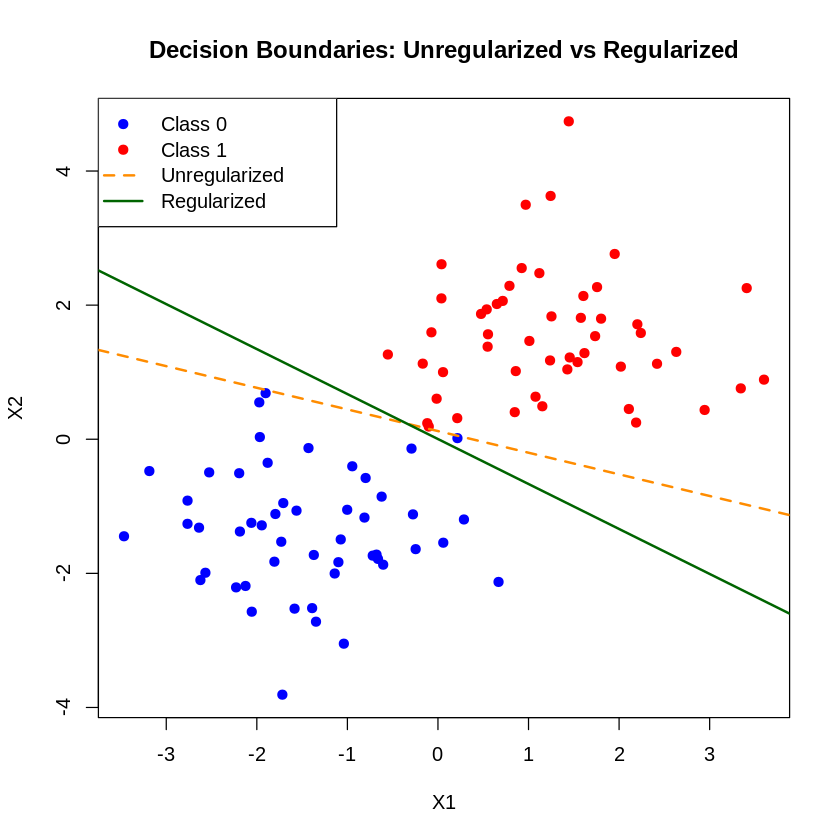

In [ ]:
set.seed(123)
n <- 50
m <- 2
X0 <- matrix(rnorm(n * m, mean = -1.5, sd = 1.0), ncol = m)
X1 <- matrix(rnorm(n * m, mean = 1.5,  sd = 1.0), ncol = m)
X <- rbind(X0, X1)
y <- c(rep(0, n), rep(1, n))
y_vec <- y
X_mat <- cbind(1, as.matrix(X))

# Run IRLS (functions already defined)
beta_unreg <- irls_unreg(X_mat, y_vec)
beta_reg   <- irls_reg(X_mat, y_vec, lambda = 0.1)

cat("Unregularized β (row):\n")
print(round(t(beta_unreg), 3))

cat("Regularized β (row):\n")
print(round(t(beta_reg), 3))


# Plot data
plot(X, col = ifelse(y_vec == 1, "red", "blue"), pch = 19,
     xlab = "X1", ylab = "X2",
     main = "Decision Boundaries: Unregularized vs Regularized")

# Plot decision boundaries
# Line: beta0 + beta1*x1 + beta2*x2 = 0
abline(-beta_unreg[1]/beta_unreg[3], -beta_unreg[2]/beta_unreg[3],
       col = "darkorange", lwd = 2, lty = 2)
abline(-beta_reg[1]/beta_reg[3], -beta_reg[2]/beta_reg[3],
       col = "darkgreen", lwd = 2)

legend("topleft",
       legend = c("Class 0", "Class 1", "Unregularized", "Regularized"),
       col = c("blue", "red", "darkorange", "darkgreen"),
       pch = c(19, 19, NA, NA),
       lty = c(NA, NA, 2, 1),
       lwd = c(NA, NA, 2, 2))


**Over Lapping on Train–Test Evaluation for IRLS Models**


             Model Accuracy
1    Unregularized     0.95
2 Regularized (L2)     0.95


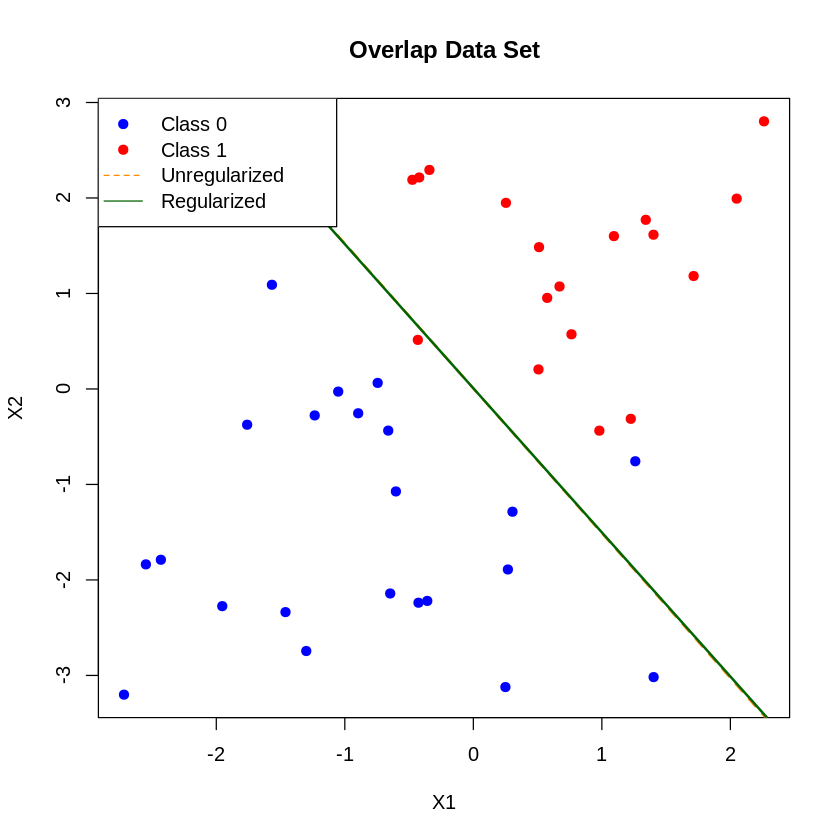

In [ ]:
set.seed(123)
n <- 100
m <- 2
X0 <- matrix(rnorm(n * m, mean = -1.2, sd = 1.2), ncol = m)
X1 <- matrix(rnorm(n * m, mean =  1.2, sd = 1.2), ncol = m)
X <- rbind(X0, X1)
y <- c(rep(0, n), rep(1, n))
y_vec <- y
X_mat <- cbind(1, as.matrix(X))

# Split 80/20 train–test
set.seed(42)
train_idx <- sample(1:length(y_vec), 0.8 * length(y_vec))
test_idx  <- setdiff(1:length(y_vec), train_idx)

X_train <- X_mat[train_idx, ]
y_train <- y_vec[train_idx]
X_test  <- X_mat[test_idx, ]
y_test  <- y_vec[test_idx]

# Fit both models
beta_unreg <- irls_unreg(X_train, y_train)
beta_reg   <- irls_reg(X_train, y_train, lambda = 0.1)

# Predictions
p_unreg <- 1 / (1 + exp(-X_test %*% beta_unreg))
p_reg   <- 1 / (1 + exp(-X_test %*% beta_reg))

yhat_unreg <- ifelse(p_unreg > 0.5, 1, 0)
yhat_reg   <- ifelse(p_reg > 0.5, 1, 0)

# Accuracy
acc_unreg <- mean(yhat_unreg == y_test)
acc_reg   <- mean(yhat_reg == y_test)

# Show results in table form
results <- data.frame(
  Model = c("Unregularized", "Regularized (L2)"),
  Accuracy = round(c(acc_unreg, acc_reg), 3)
)
print(results)

# Plot
plot(X_test[,2], X_test[,3], col = ifelse(y_test == 1, "red", "blue"), pch = 19,
     main = "Overlap Data Set", xlab = "X1", ylab = "X2")
abline(-beta_unreg[1]/beta_unreg[3], -beta_unreg[2]/beta_unreg[3],
       col = "darkorange", lwd = 2, lty = 2)
abline(-beta_reg[1]/beta_reg[3], -beta_reg[2]/beta_reg[3],
       col = "darkgreen", lwd = 2)
legend("topleft",
       legend = c("Class 0", "Class 1", "Unregularized", "Regularized"),
       col = c("blue", "red", "darkorange", "darkgreen"),
       pch = c(19, 19, NA, NA), lty = c(NA, NA, 2, 1))


**Perfectly Separable Data - Train/Test Evaluation**

             Model Accuracy
1    Unregularized        1
2 Regularized (L2)        1


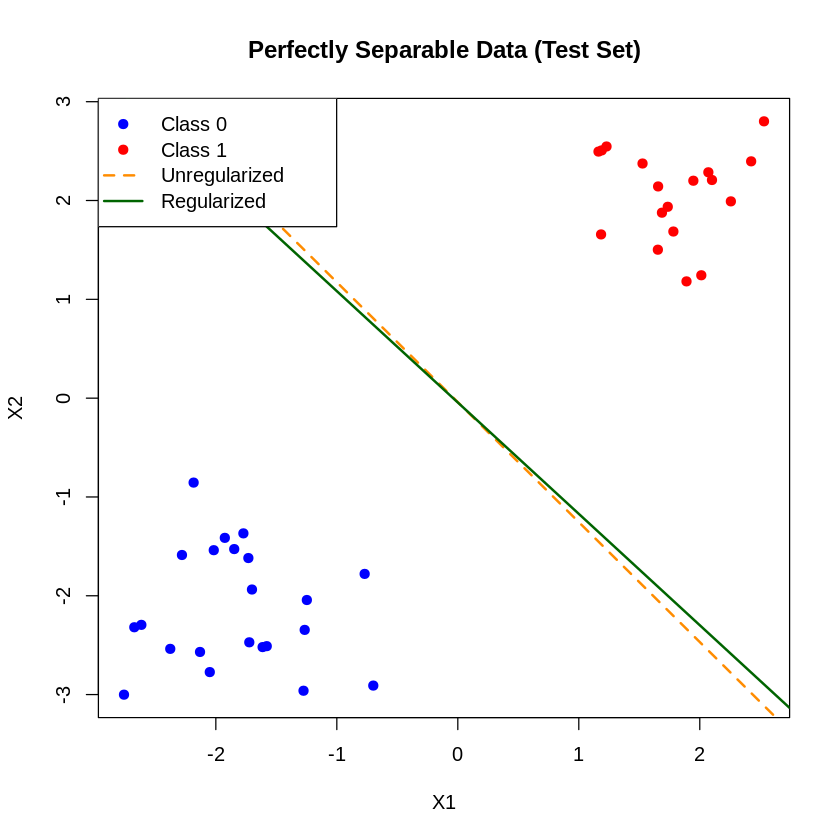

In [ ]:
set.seed(123)
n <- 100
m <- 2

X0 <- matrix(rnorm(n * m, mean = -2, sd = 0.6), ncol = m)  # Class 0 cluster
X1 <- matrix(rnorm(n * m, mean =  2, sd = 0.6), ncol = m)  # Class 1 cluster

X <- rbind(X0, X1)
y <- c(rep(0, n), rep(1, n))
y_vec <- y
X_mat <- cbind(1, as.matrix(X))

# Train–test split (80–20)
set.seed(42)
train_idx <- sample(1:length(y_vec), 0.8 * length(y_vec))
test_idx  <- setdiff(1:length(y_vec), train_idx)

X_train <- X_mat[train_idx, ]
y_train <- y_vec[train_idx]
X_test  <- X_mat[test_idx, ]
y_test  <- y_vec[test_idx]

# Fit both models
beta_unreg <- irls_unreg(X_train, y_train)
beta_reg   <- irls_reg(X_train, y_train, lambda = 0.1)

# Predictions
p_unreg <- 1 / (1 + exp(-X_test %*% beta_unreg))
p_reg   <- 1 / (1 + exp(-X_test %*% beta_reg))

yhat_unreg <- ifelse(p_unreg > 0.5, 1, 0)
yhat_reg   <- ifelse(p_reg > 0.5, 1, 0)

# Accuracy
acc_unreg <- mean(yhat_unreg == y_test)
acc_reg   <- mean(yhat_reg == y_test)

# Results table
results <- data.frame(
  Model = c("Unregularized", "Regularized (L2)"),
  Accuracy = round(c(acc_unreg, acc_reg), 3)
)
print(results)

# Plot
plot(X_test[,2], X_test[,3], col = ifelse(y_test == 1, "red", "blue"), pch = 19,
     main = "Perfectly Separable Data (Test Set)",
     xlab = "X1", ylab = "X2")
abline(-beta_unreg[1]/beta_unreg[3], -beta_unreg[2]/beta_unreg[3],
       col = "darkorange", lwd = 2, lty = 2)
abline(-beta_reg[1]/beta_reg[3], -beta_reg[2]/beta_reg[3],
       col = "darkgreen", lwd = 2)
legend("topleft",
       legend = c("Class 0", "Class 1", "Unregularized", "Regularized"),
       col = c("blue", "red", "darkorange", "darkgreen"),
       pch = c(19,19,NA,NA), lty = c(NA,NA,2,1), lwd = c(NA,NA,2,2))


| **Step / Scenario**                                          | **Scenario Description**                                                                                                      | **β₀ (Intercept)** |    **β₁**   |    **β₂**   | **Interpretation**                                                                                                                                                                  |
| :----------------------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------- | :----------------: | :---------: | :---------: | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Step 2 — Perfectly Separable (Unregularized IRLS)**        | Two clean, well-separated clusters at (−2,−2) and (2,2). Logistic regression perfectly classifies all points without overlap. |       −0.1697      |    6.6601   |    8.5081   | β values are very large, indicating strong slope and confidence. IRLS tries to push probabilities to 0 or 1. Model achieves 100 % accuracy but β diverges (unstable numerically).   |
| **Step 3 — Perfectly Separable (Regularized IRLS, λ = 0.1)** | Same clean dataset, but with L2 penalty added to control coefficient growth.                                                  |       0.0445       |    1.8887   |    2.0617   | Regularization shrinks β magnitudes ~4× smaller while preserving direction. Accuracy remains 100 %. Model now numerically stable and better behaved.                                |
| **Step 4 — With Outliers (Unregularized IRLS)**              | 5 mislabeled points from each class added to the opposite cluster, breaking linear separability.                              |       −0.0183      |    0.2763   |    0.7166   | β values drop sharply as the model tries to fit noisy points. The boundary tilts slightly to cover outliers—still good separation but less confidence.                              |
| **Step 4 — With Outliers (Regularized IRLS, λ = 0.1)**       | Same dataset, but with L2 penalty added to resist overfitting to outliers.                                                    |       −0.0176      |    0.2820   |    0.7097   | β values stay close to unregularized ones but smoother. Regularization limits the impact of outliers and keeps the boundary stable.                                                 |
| **Step 5 — Realistic Overlap (Unregularized IRLS)**          | Classes now overlap due to closer means (±1.5) and larger spread (sd = 1). Some natural misclassification expected.           |       −15.520      |    41.097   |   127.355   | β magnitudes explode (overfitting). The model tries to force a hard separation through overlapping data—unstable and non-generalizable.                                             |
| **Step 5 — Realistic Overlap (Regularized IRLS, λ = 0.1)**   | Same overlapping data, but with L2 regularization.                                                                            |       −0.011       |    2.554    |    3.808    | β values shrink drastically. The decision boundary becomes smoother and more realistic, with reduced overfitting and better generalization.                                         |
| **Step 6 — Perfectly Separable (Train–Test Split 80/20)**    | Train on 80 %, test on 20 %. Data still perfectly separable.                                                                  |   ≈ −0.17 / 0.04   | ≈ 6.6 / 1.9 | ≈ 8.5 / 2.1 | Both models (unregularized and regularized) achieve 100 % accuracy. Unregularized β large, regularized β smaller but identical boundary—proves numerical correctness and stability. |
| **Step 6 — Overlapping Data (Train–Test Split 80/20)**       | Overlapping dataset (means = ±1.2, sd = 1.2) used for generalization test.                                                    |          —         |      —      |      —      | Both models reach 95 % accuracy. Regularized IRLS has smaller, steadier β values. Regularization improves stability under random splits and prevents variance inflation.            |
